In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from rich import print
import time

In [2]:
df = pd.read_csv('train_binary.csv')#.sample(frac=0.1, random_state=37)

X_train, X_val, y_train, y_val = train_test_split(
    df.drop(['is_benign', 'category', 'attack'], axis=1),
    df['is_benign'], # "is_benign" for binary classification
    train_size=0.7, 
    random_state=37
)

### Logistic Regression

Optimising regularization parameter C (inverse of regularization strength), using GridSearch

In [3]:
# Define LogisticRegression and parameter grid
log_reg = LogisticRegression()

param_grid = {
    'penalty': ['l2'],
    'C': np.linspace(0.1, 4.0, 20), 
    'max_iter': [10000],
    'random_state': [37]
}

# Set up StratifiedKFold with random_state for reproducibility
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=37)

# Set up GridSearchCV
search = GridSearchCV(
    log_reg,
    param_grid,
    scoring=['accuracy', 'precision', 'recall', 'f1'],  # Multi-metric scoring
    refit='accuracy',  # Use accuracy to determine the best model
    cv=cv,
    verbose=True
)

In [4]:
# Start the time
start_time = time.time()

# Fit the grid search
search.fit(X_train, y_train)

# Stop the timer and print the result
elapsed_time = time.time() - start_time
print(f"\n\nElapsed time {elapsed_time:.2f} seconds")

# Access the best model and parameters
best_model = search.best_estimator_
print("\nBest Parameters by Average Score:", search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Elapsed time 358.61 seconds

Best Parameters by Average Score:
{'C': 3.5894736842105264, 'max_iter': 10000, 'penalty': 'l2', 'random_state': 37}

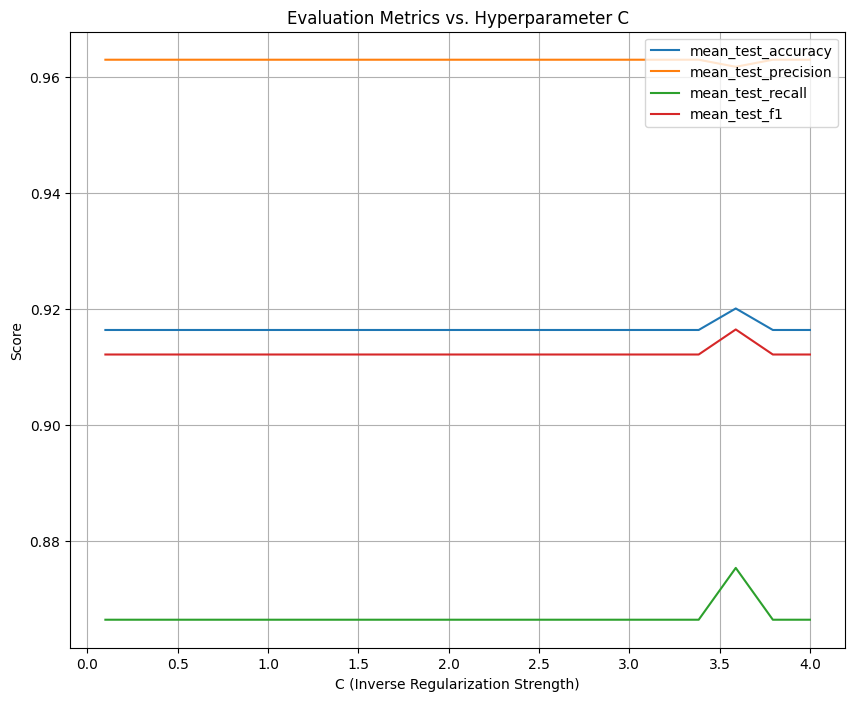

In [5]:
results = search.cv_results_

# Plot the metrics against the parameter `C`
param_values = results['param_C'].data.astype(float)
metrics = ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']

plt.figure(figsize=(10, 8))

for metric in metrics:
    plt.plot(param_values, results[metric], label=metric)

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. Hyperparameter C')
plt.legend(loc='upper right')
plt.grid()
plt.show()

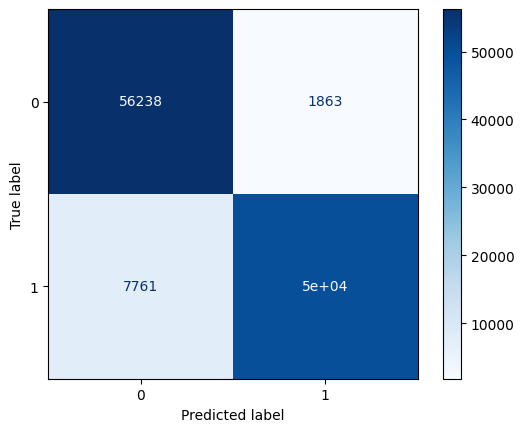

In [6]:
y_pred = best_model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

metrics_lr = [
    acc,
    prec,
    rec,
    f1
]

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

In [7]:
from joblib import dump, load

# Save the model
dump(best_model, 'log_reg_binary.joblib')

['log_reg_binary.joblib']

### RandomForest

#### Choosing the number of trees to use in the ensemble

In a Random Forest, each tree is trained on a subset of the training data selected by bootstrap sampling. The "out-of-bag" (OOB) data is the portion of the training data that was not selected during the bootstrap sampling. The OOB error is a measure of the model's predictive performance.

Observing the OOB estimation variation with the number of trees helps understanding after how many trees the model stabilizes, thus what's the optimal number of threes to train our RandomForest on. The point where the OOB error stops improving/fluctuating significantly indicates that the model generalizes well to unseen data, and adding more trees does not meaningfully improve the model's performance.


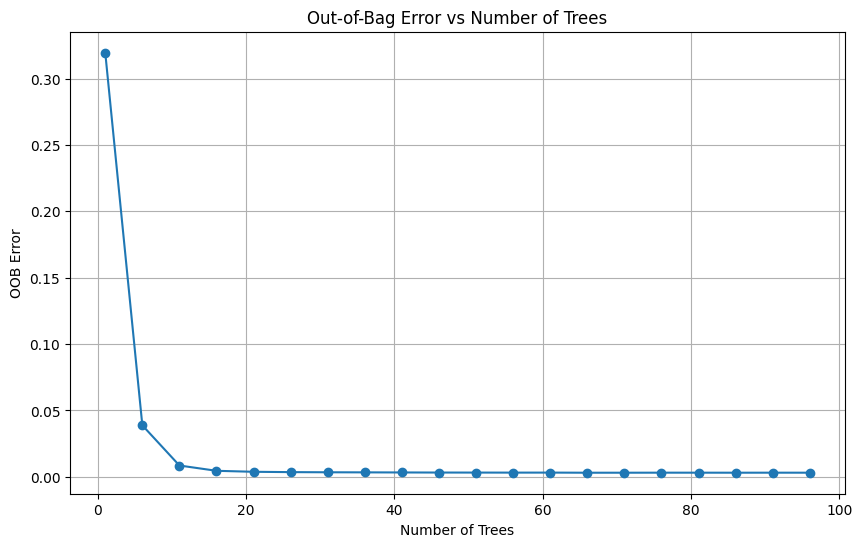

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Extract the OOB error for each number of trees: we try one model every 5 increased number of trees
oob_errors = []
n_trees_values = range(1, 100, 5)
for n_trees in n_trees_values:
    temp_forest = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=37)
    temp_forest.fit(X_train, y_train)
    oob_errors.append(1 - temp_forest.oob_score_)

# Plot the OOB error
plt.figure(figsize=(10, 6))
plt.plot(n_trees_values, oob_errors, marker='o', linestyle='-')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("Out-of-Bag Error vs Number of Trees")
plt.grid(True)
plt.show()

#### Optimising Hyperparameters

We used a Grid Search, with 3-folds cross validation, to choose the best function to measure the quality of a split ('criterion') and the best maximum depth of the trees in our ensemble ('max_depth')

We also defined a **custom scorer** function to define what we intend as "best model": the one that maximises the average of our evaluation metrics.

In [9]:
from sklearn.metrics import make_scorer

# Define average_score to take y_true and y_pred
def average_score(y_true, y_pred):
    return (accuracy_score(y_true, y_pred) + 
            precision_score(y_true, y_pred) + 
            recall_score(y_true, y_pred) + 
            f1_score(y_true, y_pred)) / 4

# Use make_scorer with the fixed average_score
average_scorer = make_scorer(average_score)

# Define RandomForestClassifier and parameter grid
rnd_forest = RandomForestClassifier()

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'random_state': [37]
}

# Set up StratifiedKFold with random_state for reproducibility
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=37)

# Set up GridSearchCV
search = GridSearchCV(
    rnd_forest,
    param_grid,
    scoring=average_scorer,  # Pass the custom scorer
    refit=True,
    cv=cv,
    verbose=True
)

In [10]:
# Start the time
start_time = time.time()

# Fit the grid search
search.fit(X_train, y_train)

# Stop the timer and print the result
elapsed_time = time.time() - start_time
print(f"\n\nElapsed time {elapsed_time:.2f} seconds")

# Access the best model and parameters
best_model = search.best_estimator_
print("\nBest Parameters by Average Score:", search.best_params_)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


Elapsed time 1870.08 seconds

Best Parameters by Average Score:
{'criterion': 'entropy', 'max_depth': None, 'random_state': 37}

#### Predicting and Evaluating the model

In [11]:
y_pred = best_model.predict(X_val)

In [12]:
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

metrics_rnd = [
    acc,
    prec,
    rec,
    f1
]

print(f"Accuracy:        {acc:.5f}")
print(f"Precision:       {prec:.5f}")
print(f"Recall:          {rec:.5f}")
print(f"F1:              {f1:.5f}")

Accuracy:        0.99697

Precision:       0.99421

Recall:          0.99974

F1:              0.99697

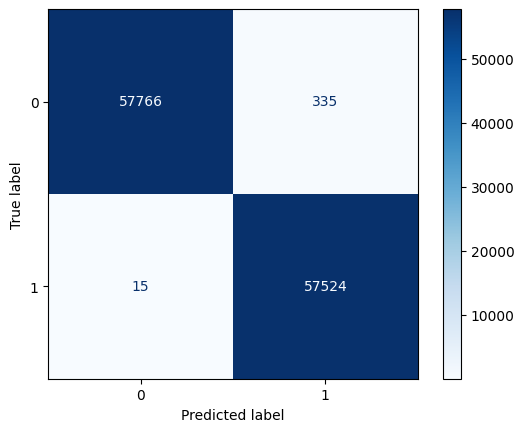

In [13]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

In [14]:
from joblib import dump, load

# Save the model
dump(best_model, 'rnd_forest_binary.joblib')

['rnd_forest_binary.joblib']

### Calibration

In [15]:
from joblib import dump, load

log_reg_binary = load('log_reg_binary.joblib')
rnd_forest_binary = load('rnd_forest_binary.joblib')

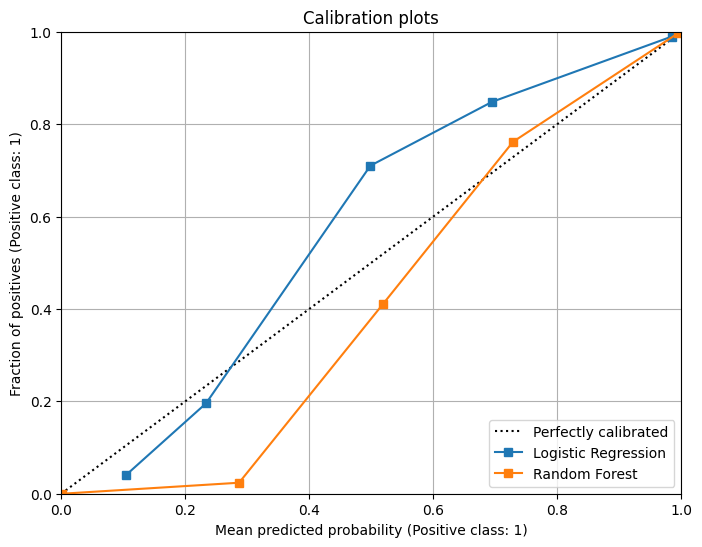

In [16]:
from sklearn.calibration import CalibrationDisplay

clf_dict = {
    'Logistic Regression': log_reg_binary,
    'Random Forest': rnd_forest_binary
}

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 1)

fig = plt.figure(figsize=(8, 6))
ax_calibration_curve = fig.add_subplot(gs[:1, :1])

calibration_displays = {}

for i, (name, clf) in enumerate(clf_dict.items()):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        name=name,
        ax=ax_calibration_curve
    )
    calibration_displays[name] = display
    
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.title("Calibration plots")
plt.show()

### ROC-AUC

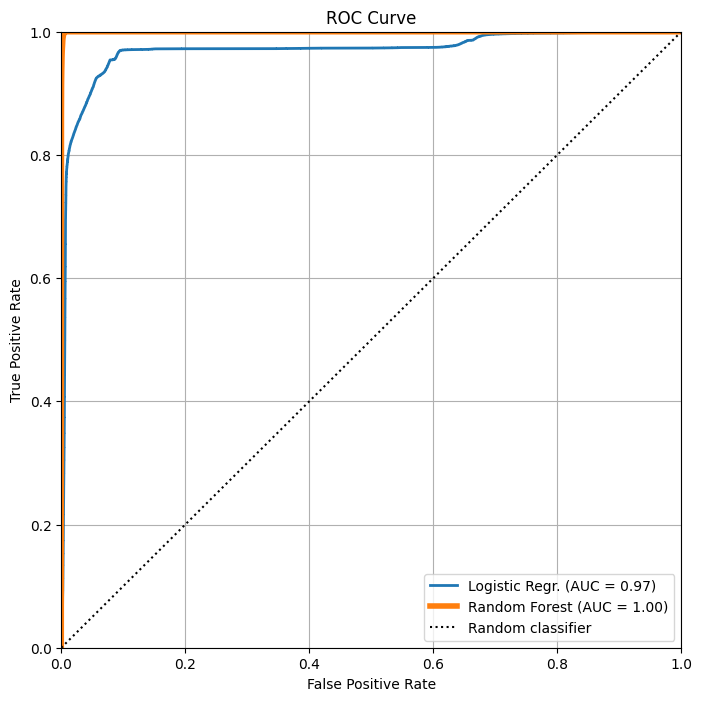

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Logistic Regression
y_proba_lr = log_reg_binary.predict_proba(X_val)
lr_fpr, lr_tpr, _ = roc_curve(y_val, y_proba_lr[:, 1])
lr_auc = roc_auc_score(y_val, y_proba_lr[:, 1])

# Random Forest
y_proba_rf = rnd_forest_binary.predict_proba(X_val)
rf_fpr, rf_tpr, _ = roc_curve(y_val, y_proba_rf[:, 1])
rf_auc = roc_auc_score(y_val, y_proba_rf[:, 1])

# Plot ROC Curves
plt.figure(figsize=(8, 8))
plt.plot(lr_fpr, lr_tpr, c='tab:blue', label=f'Logistic Regr. (AUC = {lr_auc:.2f})',  linewidth=2)
plt.plot(rf_fpr, rf_tpr, c='tab:orange', label=f'Random Forest (AUC = {rf_auc:.2f})', linewidth=4)
plt.plot([0, 1], [0, 1], 'k:', label='Random classifier')

# Formatting the plot
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the plot
plt.show()

### Testing Comparison

#### on Validation Set

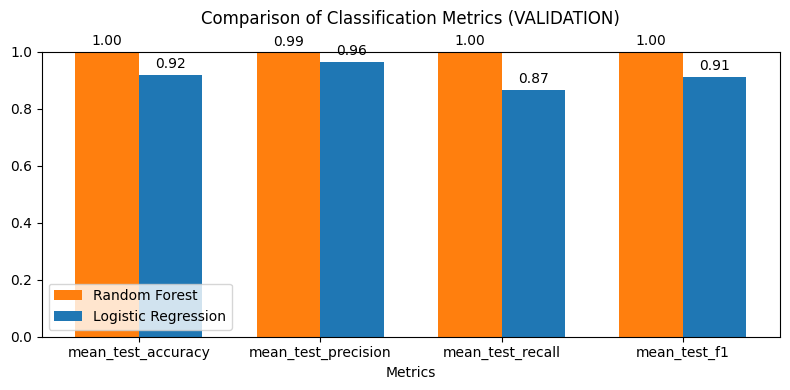

In [18]:
# Define the positions for the bars
x = np.arange(len(metrics))  # The label positions on the x-axis
width = 0.35  # Bar width

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the bars for Random Forest and Logistic Regression
rects1 = ax.bar(x - width / 2, metrics_rnd, width, label='Random Forest', color='tab:orange')
rects2 = ax.bar(x + width / 2, metrics_lr, width, label='Logistic Regression', color='tab:blue')

# Add labels, title, and customize the plot
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Classification Metrics (VALIDATION)', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1])  # Set y-axis limits to [0, 1] for percentages
ax.legend()

# Add value annotations on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to both bars
add_labels(rects1)
add_labels(rects2)

# Display the plot
plt.tight_layout()
plt.show()

#### on Test Set

In [19]:
df_test = pd.read_csv('merged_test.csv')
# Creating a boolean column 'is_benign' also for test
df_test['is_benign'] = df_test['category'].apply(lambda x: 1 if x == 'BENIGN' else 0)

cols = df.columns.intersection(df.columns)
df_test = df_test[cols]

X_test = df_test.drop(['is_benign', 'category', 'attack'], axis=1)
y_test = df_test['is_benign']

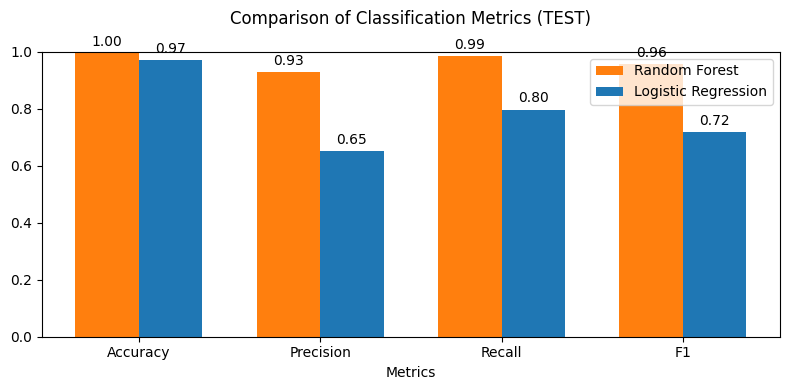

In [20]:
# Get predictions for both models
y_pred_lr = log_reg_binary.predict(X_test)
y_pred_rf = rnd_forest_binary.predict(X_test)

# Calculate metrics for Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Calculate metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

# Values for Logistic Regression and Random Forest
metrics_lr_test = [accuracy_lr, precision_lr, recall_lr, f1_lr]
metrics_rnd_test = [accuracy_rf, precision_rf, recall_rf, f1_rf]

# Define the positions for the bars
x = np.arange(len(metrics))  # The label positions on the x-axis
width = 0.35  # Bar width

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the bars for Random Forest and Logistic Regression
rects1 = ax.bar(x - width / 2, metrics_rnd_test, width, label='Random Forest', color='tab:orange')
rects2 = ax.bar(x + width / 2, metrics_lr_test, width, label='Logistic Regression', color='tab:blue')

# Add labels, title, and customize the plot
ax.set_xlabel('Metrics')
ax.set_title('Comparison of Classification Metrics (TEST)', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1])  # Set y-axis limits to [0, 1] for percentages
ax.legend()

# Add value annotations on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to both bars
add_labels(rects1)
add_labels(rects2)

# Display the plot
plt.tight_layout()
plt.show()

we can see that the RandomForest not only performs better, but is also more robust.